# Attempt to use PINNs to solve the Burgers' PDE for an arbitrary initial condition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, optim, autograd
from collections import OrderedDict

import pdb

In [2]:
class BurgersPINN(nn.Module):
    """Physics-informed neural nets (PINNS) to solve Burgers' equation."""

    def __init__(self,
                 nn_arch=[32, 16, 16, 8],
                 activation_fcn=torch.nn.Tanh,
                 misfit_fcn=torch.nn.MSELoss(),
                 freq_range=(0.5, 0.6),
                 phase_range=(-np.pi/8, np.pi/8),
                 n_ic_funcs=4,
                 n_initcond_pts=512,
                 n_boundary_pts=256,
                 n_collocation_pts=1024,
                 domain=(-1, 1, 0, 1),
                 device=None):
        """Args:
            nn_arch - number of nodes for each hidden layer of the dense NN
            activation_fcn - nn.Module nonlinearity class applied to the output
                      of hidden layer nodes (not applied to output layer)
            misfit_fcn  - training loss/objective function
            n_ic_funcs - number of random initial condition functions per step
            n_initcond_pts - number of constraint boundary points
            n_boundary_pts - number of boundary points (i.e., x = {-1, +1})
            n_collocation_pts - number of points where to test and ensure
                      that the trained PINN solves the PDE 
            domain  - tuple of dimensions of the simulation domain with
                      format (x_lb, x_ub, t_start, t_end)
            device  - compute device; defaults to "cuda:0" when available or
                      "cpu" otherwise
        """

        super().__init__()
        self._nn_arch = nn_arch
        self._activation_fcn = activation_fcn
        self._misfit_fcn = misfit_fcn
        self._freq_range = freq_range
        self._phase_range = phase_range
        self._n_ic_funcs = n_ic_funcs
        self._n_initcond_pts = n_initcond_pts
        self._n_boundary_pts = n_boundary_pts
        self._n_collocation_pts = n_collocation_pts
        self._domain = domain

        if device:
            self._device = device
        else:
            self._device = "cuda:0" if torch.cuda.is_available() else "cpu"

        # initialize neural net representation of domain
        self._layers = []
        n_inputs = 2 + 2  # (x + t) + (freq + phase)
        # .. add hidden layers
        for i, n_nodes in enumerate(nn_arch):
            self._layers.append(nn.Linear(n_inputs, n_nodes))
            self._layers.append(activation_fcn())
            n_inputs = n_nodes
        # .. add output layer
        self._layers.append(nn.Linear(n_inputs, 1))
        # .. combine layers
        self._model = nn.Sequential(*self._layers)

        # ensure model is local to the compute device
        self.to(self._device)

        # the Epanechnikov's kernel is used to taper the initial condition
        # functions and ensure that they are zero at the boundaries
        self._kernel = lambda x: np.clip(1-x**2, 0, 1)

    def forward(self, x, t, ic):
        return self._model(torch.cat([x, t, ic], axis=1))

    def pde(self, x, t, ic):
        """Burgers' PDE:
            f(x,t|u) = du/dt + u*(du/dx) - (0.01/pi)(d^2u/dx^2) = 0.
        """
        
        u = self(x, t, ic)
        u_t = autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x, create_graph=True)[0]
        return u_t + u*u_x - (0.01/np.pi)*u_xx

    def boundary_points(self):
        """Returns a batch of boundary points for training the PINN.
        Points are returned as a tuple (x, t, u).
        """

        # boundary condition points, i.e., u(x,t), x={-1, 1}
        x = np.where(np.random.rand(self._n_boundary_pts, 1) < 0.5,
                       self._domain[0], self._domain[1])
        t = np.random.uniform(low=self._domain[2], high=self._domain[3],
                              size=(self._n_boundary_pts, 1))
        u = np.zeros_like(x)

        return (self.numpy_to_tensor(x),
                self.numpy_to_tensor(t),
                self.numpy_to_tensor(u))

    def collocation_points(self):
        """Returns a batch of random collocation points."""
        
        # randomly sample locations in the (space x time) domain 
        x =  np.random.uniform(low=self._domain[0], high=self._domain[1],
                               size=(self._n_collocation_pts, 1))
        t = np.random.rand(self._n_collocation_pts, 1)

        x = self.numpy_to_tensor(x, grad=True)
        t = self.numpy_to_tensor(t, grad=True)

        return x, t

    def ic_function(self, x, freq=0.5, phase=0.0):
        """Computes an initial condition function."""
        return np.sin(2*np.pi*freq*x + phase) * self._kernel(x)

    def initial_condition_params(self, n_vecs):
        """Returns the frequency and phase params of initial conditions.
        These are returned as a matrix with `shape=(n_vecs, 2)`, to be used
        as conditional inputs for the PINN.
        """

        # parameters for the base set of IC functions for this batch
        freq = np.random.uniform(self._freq_range[0], self._freq_range[1], size=self._n_ic_funcs)
        phase = np.random.uniform(self._phase_range[0], self._phase_range[1], size=self._n_ic_funcs)

        # create list of IC parameter vectors by randomly sampling from base set
        ic_vecs = [[freq[i], phase[i]]
                   for i in np.random.randint(self._n_ic_funcs, size=n_vecs)]

        return np.array(ic_vecs)

    def initial_condition_points(self, ic_params):
        """Returns a batch of initial condition points for training the PINN.
        Points are returned as a tuple (x, t, u).
        """

        # initial condition points, i.e., u(x,t=0)
        x = np.random.uniform(low=self._domain[0], high=self._domain[1],
                              size=(self._n_initcond_pts, 1))
        t = np.full_like(x, 0)
        u = np.array([self.ic_function(v, f, p)
                      for (f, p), v in zip(ic_params[:self._n_initcond_pts], x)])

        return (self.numpy_to_tensor(x),
                self.numpy_to_tensor(t),
                self.numpy_to_tensor(u))

    def get_loss(self, mse_ic, mse_bc, mse_pde):
        """Returns combined loss and dict of individual component loss values."""
        combined_loss = mse_ic + mse_bc + mse_pde
        losses = OrderedDict([('mse_ic', mse_ic.item()),
                              ('mse_bc', mse_bc.item()),
                              ('mse_pde', mse_pde.item()),
                              ('total', combined_loss.item())])
        return combined_loss, losses

    def train(self,
              learning_rate=1e-3,
              n_iter=1000,
              disp_iter=10,
              resample_boundary_pts=True,
              resample_collocation_points=True):
        
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, amsgrad=True)

        f_vals = self.numpy_to_tensor(np.zeros((self._n_collocation_pts, 1)))

        history = pd.DataFrame(data=np.zeros((n_iter, 4)),
                               columns=['mse_ic', 'mse_bc', 'mse_pde', 'total'])
        for it in range(n_iter):
            if it==0 or resample_boundary_pts:
                xbc, tbc, ubc = self.boundary_points()
            if it==0 or resample_collocation_points:
                x_col, t_col = self.collocation_points()

            # sample initial condition parameters and compute points
            ic_params = self.initial_condition_params(max(self._n_collocation_pts,
                                                          self._n_initcond_pts,
                                                          self._n_boundary_pts))
            ic_vecs = self.numpy_to_tensor(ic_params)
            #pdb.set_trace()

            # loss on boundary points
            pred_ubc = self(xbc, tbc, ic_vecs[:self._n_boundary_pts])
            mse_bc = self._misfit_fcn(ubc, pred_ubc)

            # loss on collocation points
            pred_f = self.pde(x_col, t_col, ic_vecs[:self._n_collocation_pts])
            mse_pde = self._misfit_fcn(f_vals, pred_f)

            # loss on initial condition points
            xic, tic, uic = self.initial_condition_points(ic_params[:self._n_initcond_pts])
            pred_uic = self(xic, tic, ic_vecs[:self._n_initcond_pts])
            mse_ic = self._misfit_fcn(uic, pred_uic)

            # combined loss
            loss, losses = self.get_loss(mse_ic, mse_bc, mse_pde)
            history.iloc[it] = losses.values()

            # backprop + gradient step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if it % disp_iter == 0:
                print(f'[{it:5d}]',
                      ' '.join([f'{ln}={lv:.5f},' for ln, lv in losses.items()]))
                
        return history

    def numpy_to_tensor(self, x, grad=False):
        return torch.from_numpy(x).float().requires_grad_(grad).to(self._device)

BurgersPINN(
  (_misfit_fcn): MSELoss()
  (_model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): Tanh()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)
cuda:0
[    0] mse_ic=0.48228, mse_bc=0.23785, mse_pde=0.00004, total=0.72017,
[  500] mse_ic=0.27180, mse_bc=0.00021, mse_pde=0.00004, total=0.27205,
[ 1000] mse_ic=0.14035, mse_bc=0.00265, mse_pde=0.01148, total=0.15447,
[ 1500] mse_ic=0.08296, mse_bc=0.00097, mse_pde=0.02435, total=0.10828,
[ 2000] mse_ic=0.07238, mse_bc=0.00085, mse_pde=0.02487, total=0.09810,
[ 2500] mse_ic=0.06515, mse_bc=0.00089, mse_pde=0.02218, total=0.08823,
[ 3000] mse_ic=0.05690, mse_bc=0.00084, mse_pde=0.02184, total=0.07958,
[ 3500] mse_ic=0.05391, mse_bc=0.00057, mse_pde=0.02337, to

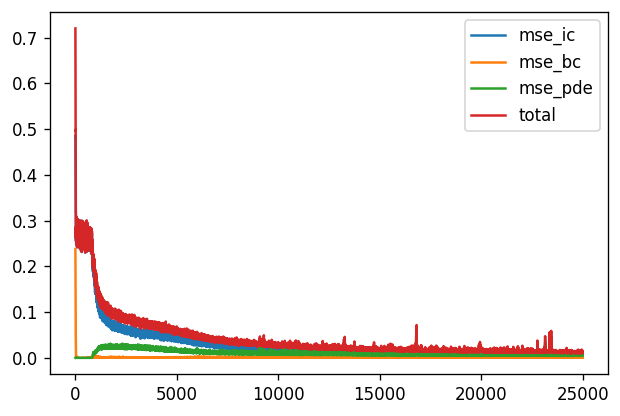

In [12]:
np.random.seed(1)
torch.manual_seed(1)
np.set_printoptions(linewidth=120, precision=3)

pinn = BurgersPINN(nn_arch=[32, 32, 16, 8],
                   freq_range=(0.5, 1.5),
                   phase_range=(-np.pi, np.pi),
                   n_ic_funcs=512,
                   n_initcond_pts=512,
                   n_collocation_pts=1024,
                   n_boundary_pts=256)
print(pinn)
print(pinn._device)

h = pinn.train(learning_rate=0.001, n_iter=25001, disp_iter=500)

plt.figure(dpi=120)
for l in h.columns:
    plt.plot(h[l], '-', label=l)
plt.legend()

In [13]:
def pinn_solution(pinn, ic_freq, ic_phase):
    xg, tg = np.meshgrid(np.linspace(-1, 1, 201), np.linspace(0, 1, 101))
    n = len(xg.ravel())
    # xg, tg = np.linspace(-1, 1, 201), np.zeros(201)
    with torch.no_grad():
        u = pinn(pinn.numpy_to_tensor(xg.reshape((-1, 1))),
                pinn.numpy_to_tensor(tg.reshape((-1, 1))),
                pinn.numpy_to_tensor(np.repeat([[ic_freq, ic_phase]], n, axis=0)))
    return xg, tg, u.cpu().numpy().reshape(xg.shape)

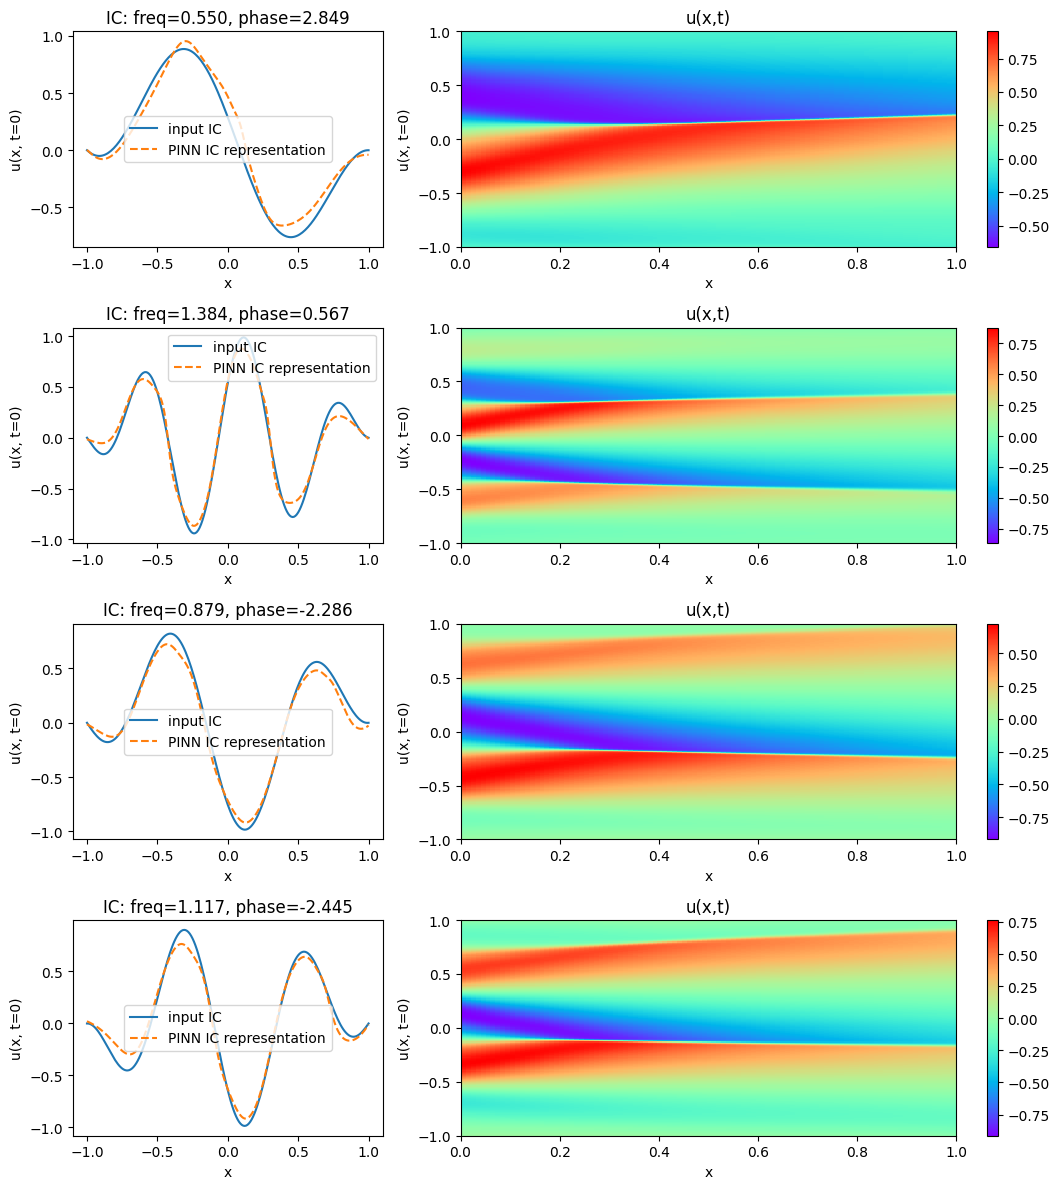

In [14]:
n_test_cases = 4
freqs = np.random.uniform(0.5, 1.5, n_test_cases)
phases = np.random.uniform(-np.pi, np.pi, n_test_cases)
fig, ax = plt.subplots(ncols=2, nrows=n_test_cases,
                       figsize=(11, 3*n_test_cases), dpi=100,
                       gridspec_kw={'width_ratios': [1, 2]})
for i, (f, p) in enumerate(zip(freqs, phases)):
    xg, tg, u = pinn_solution(pinn, f, p)

    ax[i,0].plot(xg[0], pinn.ic_function(xg[0], f, p), label='input IC')
    ax[i,0].plot(xg[0], u[0], '--', label='PINN IC representation')
    ax[i,0].set_xlabel('x')
    ax[i,0].set_ylabel('u(x, t=0)')
    ax[i,0].set_title(f'IC: freq={f:.3f}, phase={p:.3f}')
    ax[i,0].legend()

    um = ax[i,1].imshow(u.T,
                        cmap='rainbow',
                        interpolation='nearest',
                        extent=[0, 1, -1, 1],
                        origin='lower',
                        aspect='auto')
    ax[i,1].set_xlabel('x')
    ax[i,1].set_ylabel('u(x, t=0)')
    ax[i,1].set_title('u(x,t)')
    fig.colorbar(um, ax=ax[i,1])
plt.tight_layout();